# Cart-Pole Neurocontrol Example
# For CE811

### Dr Michael Fairbank, University of Essex, UK

- Email: m.fairbank@essex.ac.uk
- This is Jupyter Notebook 4.3 of a summer school course I taught for Kaunas University of Technology

## Objectives

- This notebook is an optional extension, just to show you how we can solve the pole-balancing problem using BPTT.

## The cart-pole problem
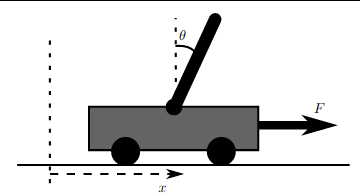

- The objective is to control the cart to move forwards and backwards so as to carefully balance the swinging pole in an upright postion
    - The cart can be controlled by applying a linear force $F$
    - The pole swings freely, balancing on its pivoted base.
    - The game is over when the pole balances beyond $\pm 12$&deg;, or the cart position $x$ exceeds $\pm 2$, or the time limit is reached.

- To see a physical cart-pole implementation, see https://www.youtube.com/watch?v=5Q14EjnOJZc

When we run this notebook, we should see the solution converge to a balanced pole.  You should see something like this:

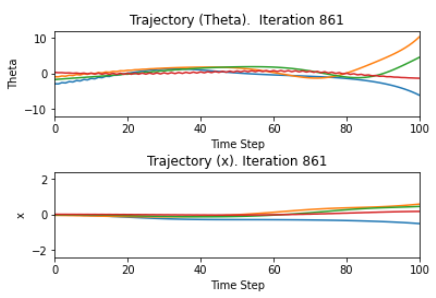

- These plots show 4 trajectories, one shown in each colour.
    - so the pole is starting from 4 different positions, and in each case completing a full balancing simulation.
- Look carefully at the theta graph, and you can deduce the pole wobbling about over time.
- Look carefully at the x graph and you can see the cart's x coordidinate slowly becoming more negative (i.e. the cart is drifting left here, in each trajectory.

### Control-Network with recurrence:
- As before, we have a known physics model of the world, and treat it like a hand-built layer to build a network with a recurrent loop:

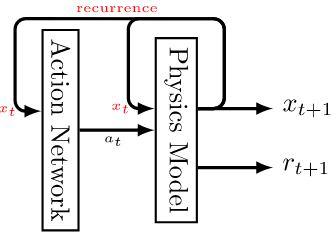


- Plus we use a neural network, the "action network", to make the decisions which control the agent (the cart in this example).

### Reward function

The reward used to train the cart-pole is given by 
$$R=-\gamma^T$$
where $T$ is the the number of time steps successfully balanced for, and $\gamma=0.97$ is the "discount factor".

Because of the minus sign and $\gamma<1$, the reward increases with $T$.

### The need for clipping
Because we need a smooth reward function to perform gradient ascent on, we have to convert $T$ into a continuous real-valued number, by doing "clipping" on the final time step. For details, see

- Fairbank, Michael, Danil Prokhorov, and Eduardo Alonso. "Clipping in neurocontrol by adaptive dynamic programming." IEEE transactions on neural networks and learning systems 25.10 (2014): 1909-1920,

or the function run_physics_model_one_step in the program code below.  

The following graphs show how clipping makes smooth gradient ascent possible for this problem.

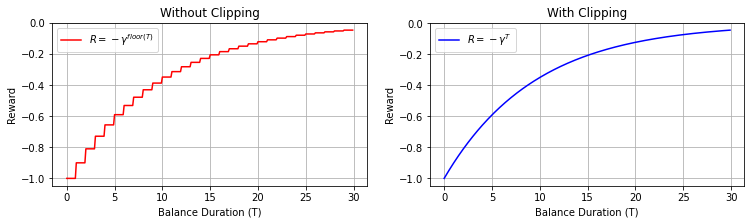

In [1]:
import numpy as np
import matplotlib.pyplot as plt
duration = np.arange(0, 30, 0.1);
fig=plt.figure(figsize=[12.4, 3])
ax1=fig.add_subplot(1,2, 1)
ax2=fig.add_subplot(1,2, 2)
ax1.plot(duration, -0.9**np.floor(duration), c='r', label="$R=-\gamma^{floor(T)}$")
ax1.set_title('Without Clipping')
ax1.set_xlabel('Balance Duration (T)')
ax1.set_ylabel('Reward')
ax1.grid(True)
ax1.legend()
ax2.plot(duration, -0.9**duration, c='b', label="$R=-\gamma^{T}$")
ax2.set_title('With Clipping')
ax2.set_xlabel('Balance Duration (T)')
ax2.set_ylabel('Reward')
ax2.grid(True)
ax2.legend()

### Build Neural Network controller (action network)

In [2]:
# Cart Pole and BPTT implementation using Keras.  
# Written for tensorflow v.2.2
# Author: m.fairbank@essex.ac.uk.  July 2020

import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

batchSize=4
state_dimension=5 # x,xdot, theta, thetaDot, timesteps
action_network_num_inputs=5 # 
action_network_num_outputs=1 



class ActionNetwork(keras.Model):
    def __init__(self):
        super(ActionNetwork, self).__init__()
        self.layer1=layers.Dense(6, activation='tanh', input_shape=(action_network_num_inputs,))
        self.layer2=layers.Dense(6, activation='tanh')
        self.output_layer=layers.Dense(action_network_num_outputs, activation='tanh')
    
    @tf.function
    def call(self, input_vector):
        x=input_vector
        y=self.layer1(x)
        x=tf.concat([x,y], axis=1)# This adds shortcut connections from the previous layer to the next layer
        y=self.layer2(x)
        x=tf.concat([x,y], axis=1)# More shortcut connections.
        y=self.output_layer(x)
        # Using the shortcut connections above means I don't need to worry 
        # too much about how many hidden layers to add.  For example, if hidden 
        # layers 1 and 2 are not needed then they can simply be skipped over.
        # Also it ensures there are shortcut connections from the input layer to the final layer, which
        # potentially allows memories in memory cells to be preserved better.
        return y


def convert_state_to_action_network_input_vector(state):
    return state*tf.constant([1.0/0.16,1,15.0/math.pi, 4,1.0/300.0],tf.float32)

keras_action_network=ActionNetwork()

### Build cart-pole physics model 

Look in the code for the physics model.
These equations can be found in, among other papers,
- Florian, Razvan V. "Correct equations for the dynamics of the cart-pole system." Center for Cognitive and Neural Studies (Coneural), Romania (2007).

In [3]:
# standard cart-pole constants:
GRAVITY = 9.8
MASSCART = 1.0
MASSPOLE = 0.1
TOTAL_MASS = (MASSPOLE + MASSCART)
LENGTH = 0.5 # // actually half the pole's length
POLEMASS_LENGTH = (MASSPOLE * LENGTH)
FORCE_MAG = 10.0
TAU = 0.02*2 # seconds between state updates.
FOURTHIRDS = 1.3333333333333
XMAX = 2.4
THETAMAX = 12.0 / 180 * math.pi

trajectory_length=100 # This is the target balance duration.  Can increase it to 300 for a greater challenge

def run_physics_model_one_step(state, action, trajectories_terminated):
    x=state[:,0]
    xdot=state[:,1]
    theta=state[:,2]
    thetadot=state[:,3]
    time_steps_elapsed=state[:,4]

    thrust=tf.reshape(action,[-1])

    # implement standard cart-pole physics model
    # See Florian, Razvan V. "Correct equations for the dynamics of the cart-pole system." 
    # Center for Cognitive and Neural Studies (Coneural), Romania (2007)
    force = (thrust) * FORCE_MAG;
    costheta = tf.cos(theta)
    sintheta = tf.sin(theta)
    temp = (force + POLEMASS_LENGTH * tf.square(thetadot) * sintheta) / TOTAL_MASS
    thetaacc = (GRAVITY * sintheta - costheta * temp) / (LENGTH * (FOURTHIRDS - MASSPOLE * costheta * costheta / TOTAL_MASS))
    xacc = temp - POLEMASS_LENGTH * thetaacc * costheta / TOTAL_MASS
    
    # Use Euler method to advance forwards in time by amount TAU
    new_theta=theta+thetadot*TAU
    new_x=x+xdot*TAU
    
    # implement clipping (necessary to make cartpole work with BPTT - see Fairbank et al 2014, 
    # "Clipping in Neurocontrol by Adaptive Dynamic Programming")
    excess_theta=tf.maximum(tf.abs(new_theta)-THETAMAX,0)
    excess_x=tf.maximum(tf.abs(new_x)-XMAX,0)
    time_to_subract_off_due_to_x_clipping=tf.where(excess_x>0,tf.abs(safe_divide(excess_x,xdot)),tf.zeros_like(excess_x))# all elements shuold be >=0
    time_to_subract_off_due_to_theta_clipping=tf.where(excess_theta>0,tf.abs(safe_divide(excess_theta,thetadot)),tf.zeros_like(excess_theta))# all elements shuold be >=0
    time_to_subtract_off_due_to_clipping=tf.maximum(time_to_subract_off_due_to_x_clipping, time_to_subract_off_due_to_theta_clipping)/TAU
    timestep_sizes=(1-time_to_subtract_off_due_to_clipping)# all the values in the vector must be between 0 and 1

    next_state=state+tf.stack([xdot*TAU*timestep_sizes, xacc*TAU*timestep_sizes, thetadot*TAU*timestep_sizes, thetaacc*TAU*timestep_sizes, timestep_sizes],axis=1)
    trajectories_terminating=tf.logical_or(time_steps_elapsed>=trajectory_length-1,tf.logical_or(excess_theta>0, excess_x>0))
    rewards=tf.zeros_like(timestep_sizes) # in cart-pole, we traditionally don't give any reward until the pole falls over.
    return [rewards, next_state, timestep_sizes, trajectories_terminating]

def evaluate_final_state(state):
    time_steps_elapsed=state[:,4]
    result=-tf.pow(0.97, time_steps_elapsed) # This is the traditional cart-pole reward function, i.e. zero reward at all time steps until the final step when it receives -1
    return result


def safe_divide(tensor_numerator, tensor_denominator):
    # attempt to avoid NaN bug in tf.where: https://github.com/tensorflow/tensorflow/issues/2540
    safe_denominator = tf.where(tf.not_equal(tensor_denominator,tf.zeros_like(tensor_denominator)), tensor_denominator, tensor_denominator+1)
    return tensor_numerator/safe_denominator

## Evaluate Trajectories

In [4]:
@tf.function    
def expand_trajectories(start_state):
    total_rewards=tf.constant(0.0, dtype=tf.float32, shape=[batchSize]) 
    state=start_state
    trajectory=tf.expand_dims(start_state,axis=0)
    trajectories_terminated=tf.cast(tf.zeros_like(initial_state[:,0]),tf.bool)

    # build main graph.  This is a long graph with unrolled in time for trajectory_length steps.  Each step includes one neural network followed by one physics-model
    
    [state,total_rewards,trajectory,trajectories_terminated]=tf.while_loop(while_loop_cond, while_loop_body, (state,total_rewards,trajectory,trajectories_terminated), shape_invariants=(state.get_shape(), total_rewards.get_shape(),tf.TensorShape([None, state.get_shape()[0], state_dimension]),trajectories_terminated.get_shape()))
    average_total_reward=tf.reduce_mean(total_rewards)
    return [average_total_reward,trajectory]

@tf.function    
def while_loop_cond(state,total_rewards,trajectory,trajectories_terminated):
    return tf.logical_not(tf.reduce_all(trajectories_terminated))
    
@tf.function    
def while_loop_body(state,total_rewards,trajectory,trajectories_terminated):
    action=keras_action_network(convert_state_to_action_network_input_vector(state))
    [rewards,next_state,timestep_sizes,trajectories_terminating]=run_physics_model_one_step(state,action,trajectories_terminated)
    state=tf.where(tf.expand_dims(trajectories_terminated,1), state, next_state)
    total_rewards+=tf.where(trajectories_terminated, tf.zeros_like(rewards), rewards)
    total_rewards+=tf.where(tf.logical_and(trajectories_terminating, tf.logical_not(trajectories_terminated)), evaluate_final_state(state), tf.zeros_like(rewards))
    trajectories_terminated=tf.logical_or(trajectories_terminated, trajectories_terminating)
    trajectory=tf.concat([trajectory, tf.expand_dims(state,axis=0)],axis=0)
    return state,total_rewards,trajectory,trajectories_terminated

# randomise initial cartpole positions:
np.random.seed(1)
initial_state=tf.constant( (np.random.rand(batchSize,state_dimension)-0.5)*0.1*[1.0,1.0,1.0,1.0,0.0], tf.float32)#[0,0,math.pi/180*12,0]

### Plot trajectories

- This will plot the trajectories and show the pole falling over 
    - (because we haven't trained the network yet).

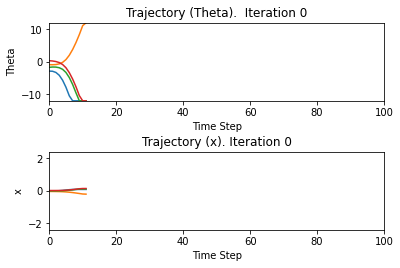

In [5]:

[average_total_reward,trajectories] = expand_trajectories(initial_state)


import matplotlib.pyplot as plt
from IPython import display
def plot_trajectories(trajectory, iteration_number, fig0):
    display.clear_output(wait=True)
    if fig0!=None:
        plt.close(fig0)
    #fig=plt.figure(figsize=[12.4, 4.8])
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
    fig.tight_layout(pad=3.0)

    ax1.axis([0,trajectory_length,-THETAMAX*180/math.pi,THETAMAX*180/math.pi])
    ax1.set(xlabel='Time Step', ylabel='Theta')
    ax1.set_title('Trajectory (Theta).  Iteration '+str(iteration_number))
    for traj in range(batchSize):
        trajectory_theta_coord=trajectory[:,traj,2]*180/math.pi
        ax1.plot(trajectory_theta_coord)
    
    ax2.axis([0,trajectory_length,-XMAX,XMAX])
    ax2.set(xlabel='Time Step', ylabel='x')
    ax2.set_title('Trajectory (x). Iteration '+str(iteration_number))
    for traj in range(batchSize):
        trajectory_x_coord=trajectory[:,traj,0]
        ax2.plot(trajectory_x_coord)
    if fig0!=None:
        display.display(plt.gcf())
    return fig
fig=None
plot_trajectories(trajectories,0,None)
duration_history=[]


## Train neural network

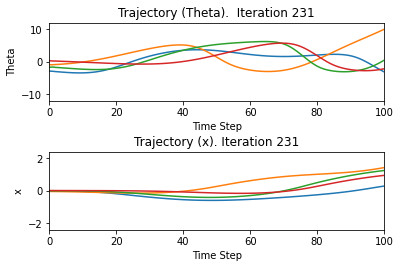

(Solved)


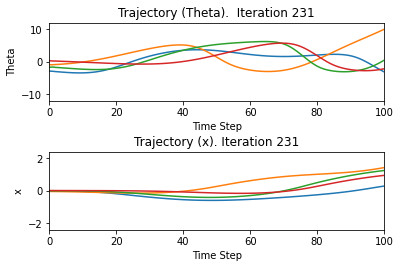

In [6]:
optimizer = keras.optimizers.Adam()
#optimizer=keras.optimizers.SGD(0.01)

for iteration in range(1000):
    with tf.GradientTape() as tape:
        # Run the forward pass of the trajectory.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        [average_total_reward,trajectory] = expand_trajectories(initial_state) 
        loss=-average_total_reward
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss, keras_action_network.trainable_weights) # The "back-propagation through time" calculation is the computation of this gradient

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, keras_action_network.trainable_weights))

    final_trajectory_steps=trajectory[-1,:]
    mean_balancing_duration=np.mean(final_trajectory_steps[:,4])
    duration_history=duration_history+[mean_balancing_duration]
    #print("iteration:",len(duration_history), "Num steps balanced:%.13f"%mean_balancing_duration)
    if (iteration%10)==0: 
        fig=plot_trajectories(trajectory, len(duration_history),fig)
        if mean_balancing_duration==trajectory_length:
            print("(Solved)")
            break

Text(0.5, 0, 'Iterations')

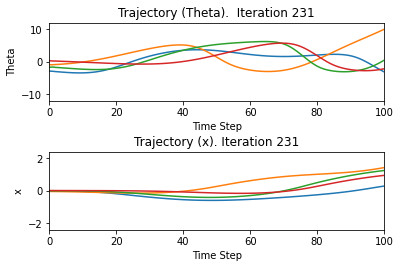

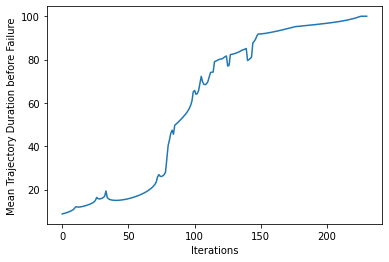

In [7]:
plot_trajectories(trajectory, len(duration_history),None)
plt.figure()
plt.plot(duration_history)
plt.ylabel('Mean Trajectory Duration before Failure')
plt.xlabel('Iterations')        

## Experiments to try:

- Try running the main learning process several times (from scratch) to see how reliable it is.
- Try increasing the trajectory length to 200 or 300 to see if it will still converge to a solution.
- See if you can work out how to switch off clipping
    - if you achieve this then this learning algorithm should fail at this problem.

## Further reading

- Reinforcement Learning (RL) is a closely related and complex topic.  
    - Unlike what we did above, RL does not allow for differentiation through the physics model
    - See https://keras.io/examples/rl/actor_critic_cartpole/ for an example of cart pole being solved with a model-free algorithm.